In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [2]:
# Load dataset from csv file
dataset = pd.read_csv('../historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
# Separate train/test
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [4]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [5]:
# All symbols
symbols = trainSet.ticker.unique()

In [6]:
timesteps = 60
def make_samples(
    data_1,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['y'][j].append(sc.transform(y))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [7]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
t = 1
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['y'][i] = []
            
    data_1 = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
        
    make_samples(
        data_1, 
        s)
    if t == 2000:
        break
    t += 1

In [8]:
# Define earlystopping callback function
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [9]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(1,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [10]:
# Training model with one feature in train_set
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(1134125, 1, 60) (1134125,)
Fitting prediction interval 1  model
Train on 793887 samples, validate on 340238 samples
Epoch 1/100
793887/793887 [==============================] - 6s 7us/step - loss: 0.0585 - val_loss: 0.0207
Epoch 2/100
793887/793887 [==============================] - 2s 2us/step - loss: 0.0261 - val_loss: 0.0169
Epoch 3/100
793887/793887 [==============================] - 2s 2us/step - loss: 0.0232 - val_loss: 0.0183
Epoch 4/100
793887/793887 [==============================] - 2s 2us/step - loss: 0.0217 - val_loss: 0.0152
Epoch 5/100
793887/793887 [==============================] - 2s 2us/step - loss: 0.0206 - val_loss: 0.0155
Epoch 6/100
793887/793887 [==============================] - 2s 2us/step - loss: 0.0198 - val_loss: 0.0136
Epoch 7/100
793887/793887 [==============================] - 2s 2us/step - loss: 0.0193 - val_loss: 0.0151
Epoch 8/100
793887/793887 [==============================] - 2s 2us/step - loss: 0.0187 - val_loss: 0.0134
Epoch 9/100
793887/793887 [

Epoch 46/100
788922/788922 [==============================] - 2s 2us/step - loss: 0.0434 - val_loss: 0.0408
Epoch 47/100
788922/788922 [==============================] - 2s 2us/step - loss: 0.0433 - val_loss: 0.0410
Epoch 48/100
788922/788922 [==============================] - 2s 2us/step - loss: 0.0433 - val_loss: 0.0406
Epoch 49/100
788922/788922 [==============================] - 2s 2us/step - loss: 0.0432 - val_loss: 0.0405
Epoch 50/100
788922/788922 [==============================] - 2s 2us/step - loss: 0.0432 - val_loss: 0.0406
Epoch 51/100
788922/788922 [==============================] - 2s 2us/step - loss: 0.0431 - val_loss: 0.0407
Epoch 52/100
788922/788922 [==============================] - 2s 2us/step - loss: 0.0431 - val_loss: 0.0407
Epoch 53/100
788922/788922 [==============================] - 2s 2us/step - loss: 0.0431 - val_loss: 0.0408
Epoch 54/100
788922/788922 [==============================] - 2s 2us/step - loss: 0.0430 - val_loss: 0.0407
(1119665, 1, 60) (1119665,)


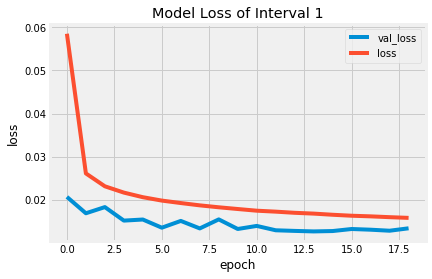

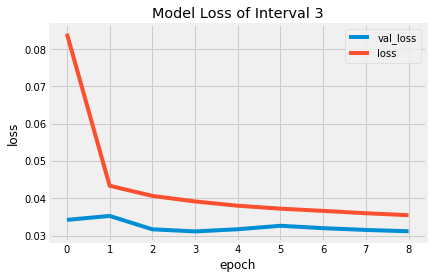

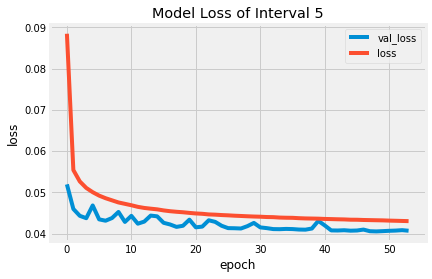

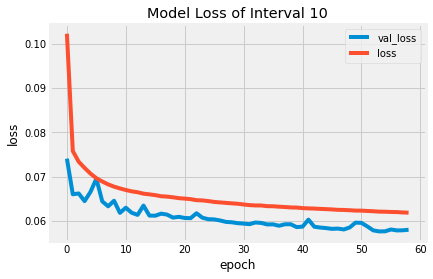

In [25]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['val_loss'])
    plt.plot(model_history[i].history['loss'])
    plt.title('Model Loss of Interval {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.show()

# Test our model

In [12]:
# Calculate Mean squared_error
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [13]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

In [14]:
# Define test_set
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    data_1 = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)

    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['y'][j].append(y)
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [15]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

## Predicting test sample

In [16]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 5.925164519213984
Test Set -> MSE of AAPL inveral 3: 25.16512885127346
Test Set -> MSE of AAPL inveral 5: 37.22331906776454
Test Set -> MSE of AAPL inveral 10: 72.84759713606428


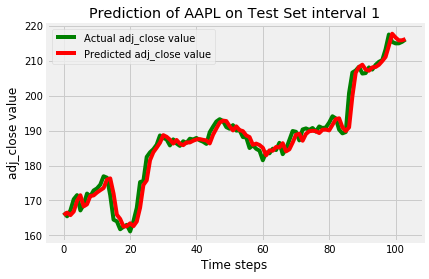

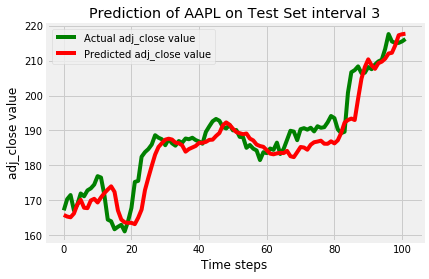

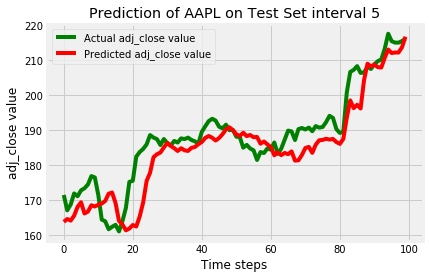

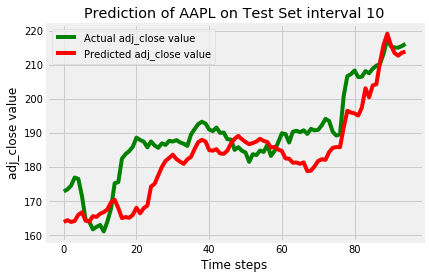

In [17]:
for i in prediction_intervals:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 5 symbols

In [18]:
test_symbols = ['A', 'ACER', 'MSFT', 'ABC', 'AAPL']

In [19]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [20]:
all_mse_1 = []
all_mse_3 = []
all_mse_5 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 2))
    all_mse_3.append(round(all_mse[s][3], 2))
    all_mse_5.append(round(all_mse[s][5], 2))
    all_mse_10.append(round(all_mse[s][10], 2))

In [21]:
# MSE of interval 1
all_mse_1

[1.19, 0.86, 1.34, 2.68, 5.93]

In [ ]:
# MSE of interval 3
all_mse_3

In [ ]:
# MSE of interval 5
all_mse_5

In [22]:
# MSE of interval 10
all_mse_10

[4.1, 3.34, 7.3, 17.53, 72.85]